# Demo script for the analyses done in Nakamura and Huang (2018, Science)

This is a complimentary demo script that can be used to implement the local wave activity and fluxes computation required in the analyses presented in

Nakamura and Huang, Atmospheric Blocking as a Traffic Jam in the Jet Stream. Science. (2018)

This notebook demonstrate how to compute local wave activity and all the flux terms in equations (2) and (3) in NH2018 with the updated functionality in the python package `hn2016_falwa`. To run the script, please install the 
package `hn2016_falwa` using
```
python setup.py install
```
after cloning the [GitHub repo](http://github.com/csyhuang/hn2016_falwa).

The functionalities are enhanced and included in the class object `QGField` under `hn2016_falwa.oopinterface`. Please refer to the [documentation](http://hn2016-falwa.readthedocs.io/) (search `QGField`) or the end of this notebook for the input/methods this class provides.

Please [raise an issue in the GitHub repo](https://github.com/csyhuang/hn2016_falwa/issues) or contact Clare S. Y. Huang (csyhuang@uchicago.edu) if you have any questions or suggestions regarding the package.

In [1]:
import numpy as np
from math import pi
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline
from hn2016_falwa.oopinterface import QGField

# Load ERA-Interim reanalysis data retrieved from ECMWF server
The sample script in this directory `download_example.py` include the code to retrieve zonal wind field U, meridional
wind field V and temperature field T at various pressure levels. Given that you have an account on ECMWF server and
have the `ecmwfapi` package installed, you can run the scripts to download data from there:
```
python download_example.py
```

In [2]:
# --- Load the zonal wind and QGPV at 240hPa --- #
u_file = Dataset('1979-01-01_to_1979-01-02_u.nc', mode='r')
v_file = Dataset('1979-01-01_to_1979-01-02_v.nc', mode='r')
t_file = Dataset('1979-01-01_to_1979-01-02_t.nc', mode='r')

print('Dimension of time: {}'.format(u_file.variables['time'].size))

Dimension of time: 8


# Load the dimension arrays
In this version, the `QGField` object takes only:
- latitude array in degree ascending order, and 
- pressure level in hPa in decending order (from ground to aloft).

In [3]:
xlon = u_file.variables['longitude'][:]

# latitude has to be in ascending order
ylat = u_file.variables['latitude'][:]
if np.diff(ylat)[0]<0:
    print('Flip ylat.')
    ylat = ylat[::-1]

# pressure level has to be in descending order (ascending height)
plev = u_file.variables['level'][:]
if np.diff(plev)[0]>0:
    print('Flip plev.')    
    plev = plev[::-1]

nlon = xlon.size
nlat = ylat.size
nlev = plev.size

Flip ylat.
Flip plev.


# Load wind/temperature field data consistent with the dimension array

In [4]:
uu = u_file.variables['u'][0, ::-1, ::-1, :].data
vv = v_file.variables['v'][0, ::-1, ::-1, :].data
tt = t_file.variables['t'][0, ::-1, ::-1, :].data

In [5]:
height = np.arange(0,48001,1000) # pseudoheight [m]
dz = 1000.                   # differential height element
dphi = 1.5*pi/180.           # differential latitudinal element
hh = 7000.                   # scale height
cp = 1004.                   # heat capacity of dry air
rr = 287.                    # gas constant
omega = 7.29e-5              # rotation rate of the earth
aa = 6.378e+6                # earth radius
kmax = 49                    # number of grid points for vertical extrapolation (dimension of height)
prefactor = 6500.            # integrated sum of density from ground to aloft
npart = nlat                 # number of partitions to construct the equivalent latitude grids
maxits = 100000              # maximum number of iteration in the SOR solver to solve for reference state
tol = 1.e-5                  # tolerance that define convergence of solution
rjac = 0.95                  # spectral radius of the Jacobi iteration in the SOR solver.              
jd = 61                      # (one plus) index of latitude grid point with value 0 deg
                             # This is to be input to fortran code. The index convention is different.


# Construct QGField object

In [6]:
test_object = QGField(xlon, ylat, plev, uu, vv, tt)


Please refer to the documentation on `oopinterface.QGField` for the details of input/output, or type `help(QGField)`.

# Interpolate fields on regular pseudoheight grid and compute QGPV

In [7]:
qgpv, interpolated_u, interpolated_v, \
    interpolated_theta, static_stability = test_object.interpolate_fields()

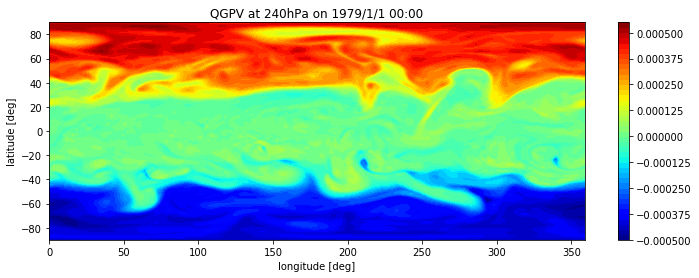

In [8]:
plt.figure(figsize=(12,4))
plt.contourf(xlon,ylat,qgpv[10,:,:], 50, cmap='jet')
plt.title('QGPV at 240hPa on 1979/1/1 00:00')
plt.ylabel('latitude [deg]')
plt.xlabel('longitude [deg]')
plt.colorbar()

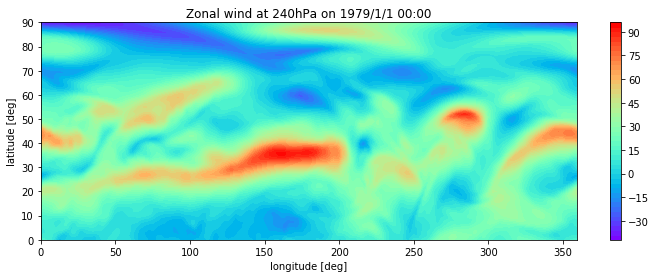

In [9]:
plt.figure(figsize=(12,4))
plt.title('Zonal wind at 240hPa on 1979/1/1 00:00')
plt.contourf(xlon,ylat[(nlat//2):],interpolated_u[10,(nlat//2):,:], 50, cmap='rainbow')
plt.ylabel('latitude [deg]')
plt.xlabel('longitude [deg]')
plt.colorbar()

# Compute reference states $Q_{ref}$, $U_{ref}$ and $\theta_{ref}$

In [10]:
qref, uref, ptref = test_object.compute_reference_states(northern_hemisphere_results_only=True)

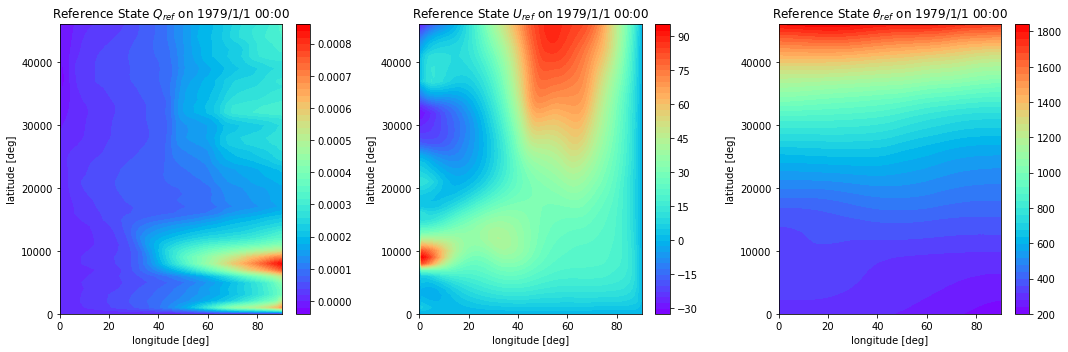

In [11]:
plt.subplots(figsize=(15,5))
plt.subplot(131)
plt.title(r'Reference State $Q_{ref}$ on 1979/1/1 00:00')
plt.contourf(ylat[(nlat//2):], height[:-2], qref[:-2,:], 50, cmap='rainbow')
plt.ylabel('latitude [deg]')
plt.xlabel('longitude [deg]')
plt.colorbar()
plt.subplot(132)
plt.title(r'Reference State $U_{ref}$ on 1979/1/1 00:00')
plt.contourf(ylat[(nlat//2):], height[:-2], uref[:-2,:], 50, cmap='rainbow')
plt.ylabel('latitude [deg]')
plt.xlabel('longitude [deg]')
plt.colorbar()
plt.subplot(133)
plt.title(r'Reference State $\theta_{ref}$ on 1979/1/1 00:00')
plt.contourf(ylat[(nlat//2):], height[:-2], ptref[:-2,:], 50, cmap='rainbow')
plt.ylabel('latitude [deg]')
plt.xlabel('longitude [deg]')
plt.colorbar()
plt.tight_layout()

# Compute different components of barotropic wave activity fluxes

Type `help(test_object.compute_reference_states)` to see the what terms in the flux equation the variables correspond to.

In [12]:
adv_flux_f1, adv_flux_f2, adv_flux_f3, divergence_eddy_momentum_flux, meridional_heat_flux, \
    lwa_baro, u_baro, lwa = test_object.compute_lwa_and_barotropic_fluxes()

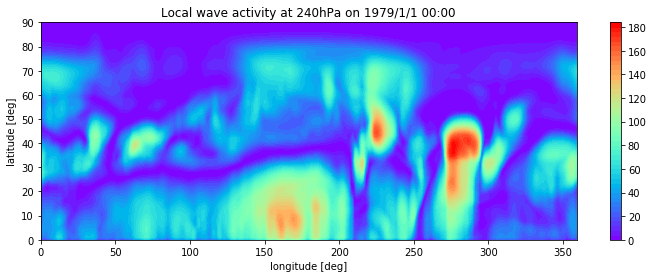

In [13]:
plt.figure(figsize=(12,4))
plt.title('Local wave activity at 240hPa on 1979/1/1 00:00')
plt.contourf(xlon,ylat[(nlat//2):],lwa[10,:,:], 50, cmap='rainbow')
plt.ylabel('latitude [deg]')
plt.xlabel('longitude [deg]')
plt.colorbar()

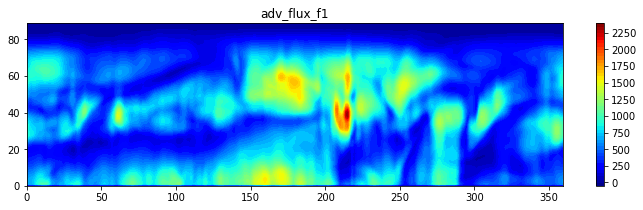

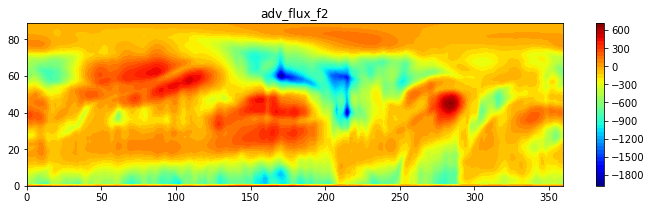

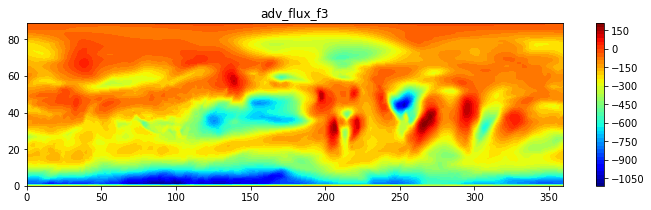

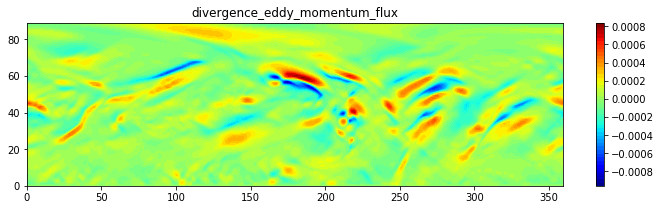

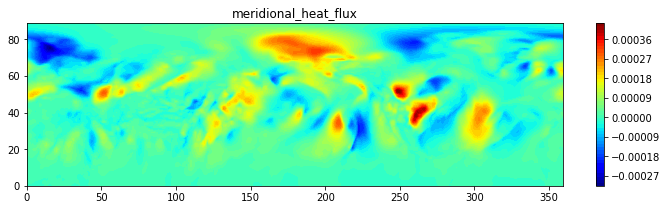

In [14]:
for variable, name in zip([adv_flux_f1, adv_flux_f2, adv_flux_f3,
                           divergence_eddy_momentum_flux, meridional_heat_flux],
                          ['adv_flux_f1', 'adv_flux_f2', 'adv_flux_f3',
                           'divergence_eddy_momentum_flux', 'meridional_heat_flux']):

    plt.figure(figsize=(12,3))
    plt.contourf(xlon, ylat[(nlat//2):-1], variable[:-1,:], 50, cmap='jet')
    plt.colorbar()
    plt.title(name)
    plt.show()

In [15]:
help(QGField)

Help on class QGField in module hn2016_falwa.oopinterface:

class QGField(builtins.object)
 |  Local wave activity and flux analysis in quasi-geostrophic framework
 |  that can be used to reproduce the results in:
 |  Nakamura and Huang, Atmospheric Blocking as a Traffic Jam in the Jet Stream, Science (2018)
 |  Note that topography is assumed flat in this object.
 |  
 |  
 |  .. versionadded:: 0.3.0
 |  Parameters
 |  ----------
 |  xlon : numpy.array
 |         Array of longitude (in degree) of size nlon.
 |  ylat : numpy.array
 |         Array of latitude (in degree) of size nlat.
 |  plev : numpy.
 |         Array of pressure level (in hPa) of size nlev.
 |  u_field : numpy.ndarray
 |         Three-dimensional array of zonal wind field (in m/s) of dimension [nlev, nlat, nlon].
 |  v_field : numpy.ndarray
 |         Three-dimensional array of meridional wind field (in m/s) of dimension [nlev, nlat, nlon].
 |  t_field : numpy.ndarray
 |         Three-dimensional array of temperature